In [1]:
# !pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import sys
sys.path.insert(1, '/home/smatthe2/sciope')
sys.path.insert(1, '/home/smatthe2/GillesPy2')
import sciope
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver

import matplotlib.pyplot as plt

# devils_v1.0
- Need to validate timespan

In [2]:
class Devilsv101(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression=".029"))
        self.add_parameter(Parameter(name="K", expression="217"))
        self.add_parameter(Parameter(name="ds", expression=".0058"))
        self.add_parameter(Parameter(name="dI", expression=".044"))
        self.add_parameter(Parameter(name="L", expression="27.39"))
        self.add_parameter(Parameter(name="k0", expression="0.48"))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=0, mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I':1}, propensity_function="k0*S*I/K"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))

        # Timespan
        self.timespan(np.linspace(0, 288, 289)) # month data tspan

In [3]:
model = Devilsv101()
print(len(model.tspan))

289


# Model Inference

In [4]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared, euclidean, manhattan
from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.utilities.epsilonselectors import RelativeEpsilonSelector
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

## Generate some fixed(observed) data based on default parameters of the model

In [5]:
import pandas as pd

# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values[132:])
init_devils_pop = devil_pop[0]
dftd_pop = .1*init_devils_pop

model.listOfParameters['K'].expression = max(devil_pop)*1.3

model.listOfSpecies['Devils'].initial_value = init_devils_pop
model.listOfSpecies['I'].initial_value = round(init_devils_pop*.001)  # This will be overwritten by variables later
model.listOfSpecies['S'].initial_value = round(init_devils_pop*.999)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
print(obs)
print(model)

[[[53276.93155 53276.93155 53214.09914 53151.26672 53151.26672
   53151.26672 53088.43431 53025.60189 52962.76948 52962.76948
   52899.93706 52899.93706 52837.10465 52899.93706 52899.93706
   52962.76948 53025.60189 53025.60189 53088.43431 53151.26672
   53214.09914 53276.93155 53339.76397 53339.76397 53339.76397
   53276.93155 53151.26672 53025.60189 52899.93706 52774.27223
   52522.94257 52397.27774 52271.61291 52145.94808 52020.28325
   51894.61841 51831.786   51706.12117 51706.12117 51643.28875
   51643.28875 51580.45634 51580.45634 51517.62392 51517.62392
   51517.62392 51454.79151 51454.79151 51454.79151 51391.95909
   51266.29426 51203.46184 51014.9646  50952.13218 50826.46735
   50700.80252 50700.80252 50637.97011 50575.13769 50449.47286
   50386.64044 50386.64044 50323.80803 50260.97561 50198.1432
   50135.31078 50135.31078 50135.31078 50072.47837 50072.47837
   50009.64595 49946.81354 49883.98112 49695.48388 49381.3218
   49129.99214 48878.66248 48752.99764 48564.5004  48376.

In [6]:
def configure_simulation():
    solver = ODECSolver(model=model)
    kwargs = {
        "solver":solver,
#         "number_of_trajectories":100,
#         "seed":None,
#         "tau_tol":0.03,
#         "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [7]:
kwargs = configure_simulation()

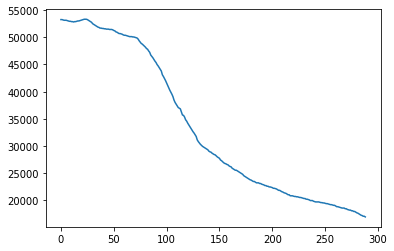

In [8]:
plt.plot(model.tspan, devil_pop)
# plt.plot(model.tspan, dfdt_pop)

In [9]:
results = model.run(solver=ODECSolver)
results.plotplotly()

{}


## Define prior distribution

In [10]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)
# bound = np.log(bound)
# Set the bounds
bound = np.array(bound)
dmin = np.log(bound * 0.5)
dmax = np.log(bound * 5.0)
# dmin = bound * 0.5
# dmax = bound * 5.0

print(dmin)
print(dmax)
# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

['r', 'K', 'ds', 'dI', 'L', 'k0']
[0.029, 69341.693161, 0.0058, 0.044, 27.39, 0.48]
[-4.23360663 10.45365446 -5.84304454 -3.81671283  2.6170308  -1.42711636]
[-1.93102154 12.75623955 -3.54045945 -1.51412773  4.9196159   0.87546874]


In [11]:
# parameter_names = ['r',    'K',   'L',   'k0']
# lower_bounds =    [.002,   45000, .003,  .06]
# upper_bounds =    [.04,    75000, .04,   .7]
# uni_prior = uniform_prior.UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Define simulator

In [12]:
def set_model_parameters(params, model):
    # params - array, need to have the same order as model.listOfParameters
    for e, pname in enumerate(model.listOfParameters.keys()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# Here we use the GillesPy2 Solver
def simulator(params, model):
    print('testing params:\n', params)
    params = np.exp(params)
    print(params)
    model_update = set_model_parameters(params, model)

    res = model_update.run(**kwargs)
#     res = res.to_array()
#     tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
#     # should not contain timepoints
#     tot_res = tot_res[:, 1:, :]
    devils = res['Devils']
#     infected = res['I']

    return np.vstack([devils]).reshape(1, 1, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [13]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
ed = euclidean.EuclideanDistance()
mh = manhattan.ManhattanDistance()

## Start local cluster using dask client

In [14]:
c = Client()

## Start abc instance

In [15]:
abc = SMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute,
                          distance_function=mh
                         )
# abc.compute_fixed_mean(1)

In [16]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [17]:
max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=1, eps_selector=eps_selector)

<Client: 'tcp://127.0.0.1:45353' processes=4 threads=8, memory=8.15 GB>
Determining initial population using 20
Starting epsilon = 30915401.031485356
Starting epsilon = 6151972.574985446
Starting epsilon = 2208082.6503562503
Starting epsilon = 1242802.148021435
Starting epsilon = 489373.0976106589


In [18]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])
res[0]

{'accepted_samples': [array([-2.12784832, 10.70394572, -3.54281648, -1.89601055,  4.84097089,
         -0.19619374]),
  array([-2.13876572, 11.07014137, -5.1745162 , -1.60467286,  3.30133101,
         -0.97024991]),
  array([-2.98048621, 12.28333905, -4.35855815, -2.31134002,  2.88558035,
         -0.51458024]),
  array([-3.28482197, 11.48961708, -5.33623123, -3.42508798,  3.73784337,
          0.62084846]),
  array([-2.40456562, 12.12480002, -5.2876782 , -2.55516211,  2.85245701,
         -0.7915347 ]),
  array([-3.19055166, 12.12645547, -4.26653249, -3.06940887,  4.30705543,
         -0.14256249]),
  array([-2.90376593, 11.45455975, -4.11373403, -2.95722139,  2.66882964,
         -0.13579494]),
  array([-3.89368675, 12.59364804, -3.59549546, -2.45884097,  3.05829167,
         -1.21188136]),
  array([-3.19428025, 12.42085024, -5.30721883, -2.33985806,  3.64608107,
          0.33187914]),
  array([-2.9509044 , 12.39886546, -5.70800081, -3.77066601,  4.13587402,
          0.37841011]),


## Analysis

In [19]:
posterior = np.array(res[0]['accepted_samples'])

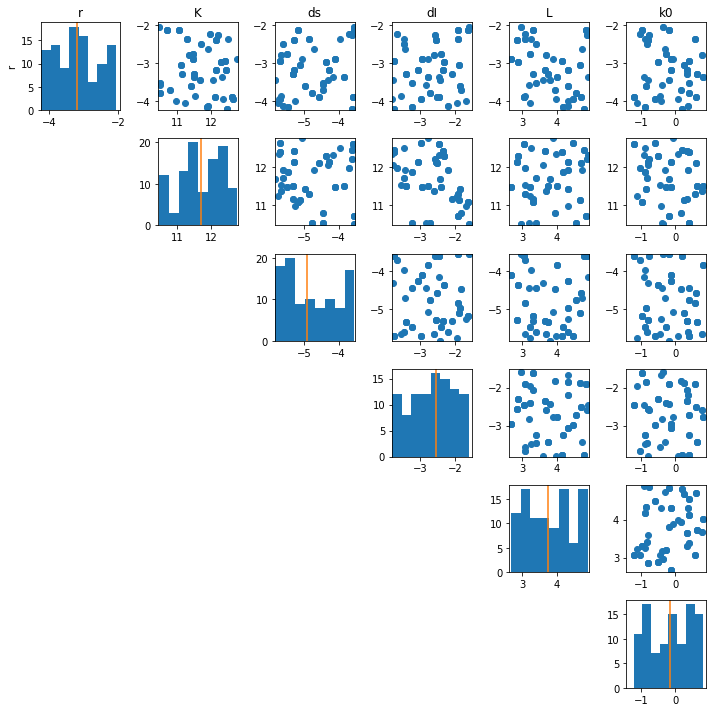

In [20]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(dmin[i], dmax[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(dmin[i], dmax[i])
                ax[i,j].set_xlim(dmin[j], dmax[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

In [21]:
# for i in range(posterior.shape[0]):
#     res = simulator2(posterior[i,:])
#     plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [22]:
res = simulator2(posterior[10,:])
print(res)
# plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

testing params:
 [-2.12784832 10.70394572 -3.54281648 -1.89601055  4.84097089 -0.19619374]
[    0.11909327 44531.21662377     0.02893173     0.15016651
   126.59219949     0.821853  ]
{}
[[[53276.9 50733.  48612.2 46823.6 45300.7 43993.6 42863.5 41880.7
   41021.2 40266.2 39600.4 39011.  38487.6 38021.5 37605.3 37233.
   36899.3 36599.5 36329.8 36086.8 35867.5 35669.4 35490.4 35328.3
   35181.5 35048.4 34927.7 34818.1 34718.5 34628.1 34545.8 34471.
   34402.9 34340.9 34284.4 34233.  34186.2 34143.5 34104.6 34069.1
   34036.7 34007.2 33980.3 33955.7 33933.3 33912.9 33894.2 33877.2
   33861.6 33847.5 33834.5 33822.8 33812.  33802.2 33793.2 33785.
   33777.6 33770.7 33764.5 33758.8 33753.6 33748.8 33744.5 33740.5
   33736.9 33733.5 33730.5 33727.7 33725.2 33722.9 33720.8 33718.9
   33717.2 33715.6 33714.2 33712.9 33711.7 33710.6 33709.6 33708.7
   33707.9 33707.2 33706.5 33705.9 33705.3 33704.8 33704.3 33703.9
   33703.6 33703.2 33702.9 33702.6 33702.4 33702.2 33702.  33701.8
   33701.7 3

In [23]:
print(simulator2(posterior[0]))

testing params:
 [-2.12784832 10.70394572 -3.54281648 -1.89601055  4.84097089 -0.19619374]
[    0.11909327 44531.21662377     0.02893173     0.15016651
   126.59219949     0.821853  ]
{}
[[[53276.9 50733.  48612.2 46823.6 45300.7 43993.6 42863.5 41880.7
   41021.2 40266.2 39600.4 39011.  38487.6 38021.5 37605.3 37233.
   36899.3 36599.5 36329.8 36086.8 35867.5 35669.4 35490.4 35328.3
   35181.5 35048.4 34927.7 34818.1 34718.5 34628.1 34545.8 34471.
   34402.9 34340.9 34284.4 34233.  34186.2 34143.5 34104.6 34069.1
   34036.7 34007.2 33980.3 33955.7 33933.3 33912.9 33894.2 33877.2
   33861.6 33847.5 33834.5 33822.8 33812.  33802.2 33793.2 33785.
   33777.6 33770.7 33764.5 33758.8 33753.6 33748.8 33744.5 33740.5
   33736.9 33733.5 33730.5 33727.7 33725.2 33722.9 33720.8 33718.9
   33717.2 33715.6 33714.2 33712.9 33711.7 33710.6 33709.6 33708.7
   33707.9 33707.2 33706.5 33705.9 33705.3 33704.8 33704.3 33703.9
   33703.6 33703.2 33702.9 33702.6 33702.4 33702.2 33702.  33701.8
   33701.7 3

In [25]:
simulator2(posterior[0]).plot()

testing params:
 [-2.12784832 10.70394572 -3.54281648 -1.89601055  4.84097089 -0.19619374]
[    0.11909327 44531.21662377     0.02893173     0.15016651
   126.59219949     0.821853  ]
{}


AttributeError: 'numpy.ndarray' object has no attribute 'plot'